In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import *
from tqdm import tqdm
import math
from numba import njit
import random

plt.rcParams["figure.figsize"] = [14, 8]
plt.rcParams["figure.dpi"] = 100
plt.set_cmap("binary_r")

<Figure size 1400x800 with 0 Axes>

# Code for excecuting the actions of the agent
This is essensially the same code as the provided one but optimized with numba.

In [213]:
@njit
def painter_play(rules, room):
    M, N = room.shape
    t = M * N - np.sum(room)
    t = int(t)

    env = np.ones((M + 2, N + 2))
    for i in range(1, M + 1):
        for j in range(1, N + 1):
            env[i][j] = 0

    M = M + 2
    N = N + 2

    xpos = np.full((t + 1,), np.nan)
    ypos = np.full((t + 1,), np.nan)

    while True:
        xpos[0] = np.floor(M * np.random.random())
        ypos[0] = np.floor(N * np.random.random())
        if env[int(xpos[0]), int(ypos[0])] == 0:
            break

    direction = np.floor(4 * np.random.random()) - 2
    score = 0

    for i in range(t):
        dx = divmod(direction, 2)[1]
        if direction == -1:
            dx = -1 * dx

        dy = divmod(direction + 1, 2)[1]
        if direction == -2:
            dy = -1 * dy

        r_direction = direction + 1
        if r_direction == 2:
            r_direction = -2

        dxr = divmod(r_direction, 2)[1]
        if r_direction == -1:
            dxr = -1 * dxr
        dyr = divmod(r_direction + 1, 2)[1]
        if r_direction == -2:
            dyr = -1 * dyr

        local = np.array([env[int(xpos[i] + dx), int(ypos[i] + dy)], env[int(xpos[i] - dxr), int(ypos[i] - dyr)],
                          env[int(xpos[i] + dxr), int(ypos[i] + dyr)]])

        localnum = int(2 * np.dot(1.0 * np.array([9, 3, 1]), local))
        if env[int(xpos[i]), int(ypos[i])] == 2:
            localnum += 1

        if rules[localnum] == 3:
            dirchange = np.floor(np.random.random() * 2) + 1
        else:
            dirchange = rules[localnum]

        if dirchange == 1:
            direction = direction - 1
            if direction == -3:
                direction = 1
        elif dirchange == 2:
            direction = direction + 1
            if direction == 2:
                direction = -2

        dx = divmod(direction, 2)[1]
        if direction == -1:
            dx = -1 * dx

        dy = divmod(direction + 1, 2)[1]
        if direction == -2:
            dy = -1 * dy

        if env[int(xpos[i]), int(ypos[i])] == 0:
            env[int(xpos[i]), int(ypos[i])] = 2
            score = score + 1

        if env[int(xpos[i] + dx), int(ypos[i] + dy)] == 1:
            xpos[i + 1] = xpos[i]
            ypos[i + 1] = ypos[i]
        else:
            xpos[i + 1] = xpos[i] + dx
            ypos[i + 1] = ypos[i] + dy

    score = score / t

    return score, xpos, ypos


test_room = np.zeros((8, 7))
test_rules = np.ones((54,))
for i in range(len(test_rules)):
    test_rules[i] = 3

print(painter_play(test_rules, test_room))

(0.3392857142857143, array([4., 4., 3., 3., 4., 4., 5., 5., 4., 4., 5., 5., 4., 4., 5., 5., 6.,
       6., 7., 7., 6., 6., 7., 7., 8., 8., 8., 8., 8., 8., 7., 7., 6., 6.,
       7., 7., 8., 8., 8., 8., 7., 7., 6., 6., 5., 5., 6., 6., 5., 5., 4.,
       4., 3., 3., 4., 4., 5.]), array([3., 4., 4., 3., 3., 4., 4., 3., 3., 4., 4., 5., 5., 4., 4., 3., 3.,
       2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 2., 2., 3., 3., 2., 2., 3., 3., 4., 4., 3., 3., 2., 2., 3., 3.,
       4., 4., 3., 3., 4., 4.]))


# Genetic algorithm
The overall structure of the GA is gives as follows:
1. Initialization: Start with $N = 100$ random initialization of the action space, expressed as N 1x54 arrays where each entry have some value \{0,1,2,3\} that correspond to the possible actions the agent can take.

2. Fitness: Compute the fitness of all the agents by computing the fraction of painted squares relative the number of available squares. This is automatically done using the painter_play function.

3. Selection: Randomly pick five chromosomes and compute their respective fitness. Pick the chromosome that have the best fitness and store it. Repeat this N times so we can obatain a new population that have better fitness than the previous generation.

4. Crossover: Pick two chromosomes and find a random place to split them. Pick the first part of the first chromosome and the last part of the second chromosome and paste them together. Repeat this by pasting together the first part of the second chromosome with the last part of the first chromosome. The result will be two new children chromosome that have the traits of their parents. This crossover process is then repeated for every neighboring pairs of chromosomes from the selected population. 

5. Mutation: Assign some non-zero probability to randomly switch the value of the chromosome. This is repeated for all the chromosomes with mutate_all function.

6. Update: The mutated generation is now likely to be better than the generation before the selection process, so we replace the old generation with the new one. 
7. Compute the avreage fitness of the new generation for visualization porpurses. 

In [229]:
# Initialize population
N = 10
Nx, Ny = 30, 40
room = np.zeros([Nx, Ny])
chromosome_length = 54
population = np.random.randint(0, 4, (N, chromosome_length))

# Fitness function for one chromosome
@njit
def fitness(chromosome):
    # Use the painter_play function to calculate the fitness of a chromosome
    score, _, _ = painter_play(chromosome, room)
    return score

# Function for computing averrage fitness
@njit
def calculate_average_fitness(population):
    # Preallocate the array for the fitness scores
    fitness_scores = np.empty(N, dtype=np.float64)
    for i in range(N):
        fitness_scores[i] = fitness(population[i])
    return np.mean(fitness_scores)


# Selection function
def selection(population):
    # Tournament selection
    tournament_size = 5
    selected = []
    for _ in range(N):
        # Select indices for tournament, not the chromosomes themselves
        tournament_indices = np.random.choice(len(population), size=tournament_size, replace=False)
        tournament = population[tournament_indices]
        fitnesses = [fitness(chromosome) for chromosome in tournament]
        winner_index = tournament_indices[np.argmax(fitnesses)]
        selected.append(population[winner_index])
    return np.array(selected)


# Crossover function
@njit
def crossover(parent1, parent2):
    # One-point crossover
    # Picking some random location in the parent chromosome and split there
    point = np.random.randint(0, chromosome_length)
    # Paste together the different pieces of the chromosomes to form the childrens
    child1 = np.concatenate((parent1[:point], parent2[point:]))
    child2 = np.concatenate((parent2[:point], parent1[point:]))
    return child1, child2


@njit
def crossover_all(selected):
    # Preallocate the array for the children
    children = np.empty((N, chromosome_length), dtype=np.int64)
    for i in range(0, N, 2):
        children[i], children[i+1] = crossover(selected[i], selected[i+1])
    return children


# Mutation function
@njit
def mutation(chromosome):
    # Bit-flip mutation
    for i in range(chromosome_length):
        if np.random.rand() < 0.005:  # mutation rate
            chromosome[i] = np.random.randint(0, 4)
    return chromosome

@njit
def mutate_all(children):
    # Preallocate the array for the mutated children
    mutated = np.empty((N, chromosome_length), dtype=np.int64)
    for i in range(N):
        mutated[i] = mutation(children[i])
    return mutated


fitness_history = [] 
for generation in tqdm(range(100)):  # number of generations
    # Selection
    selected = selection(population)

    # Crossover
    children = crossover_all(selected)

    # Mutation
    mutated = mutate_all(children)

    # Update population
    population = mutated

    # Calculate average fitness
    avg_fitness = calculate_average_fitness(population)

    fitness_history.append(avg_fitness)

100%|██████████| 100/100 [00:05<00:00, 19.61it/s]


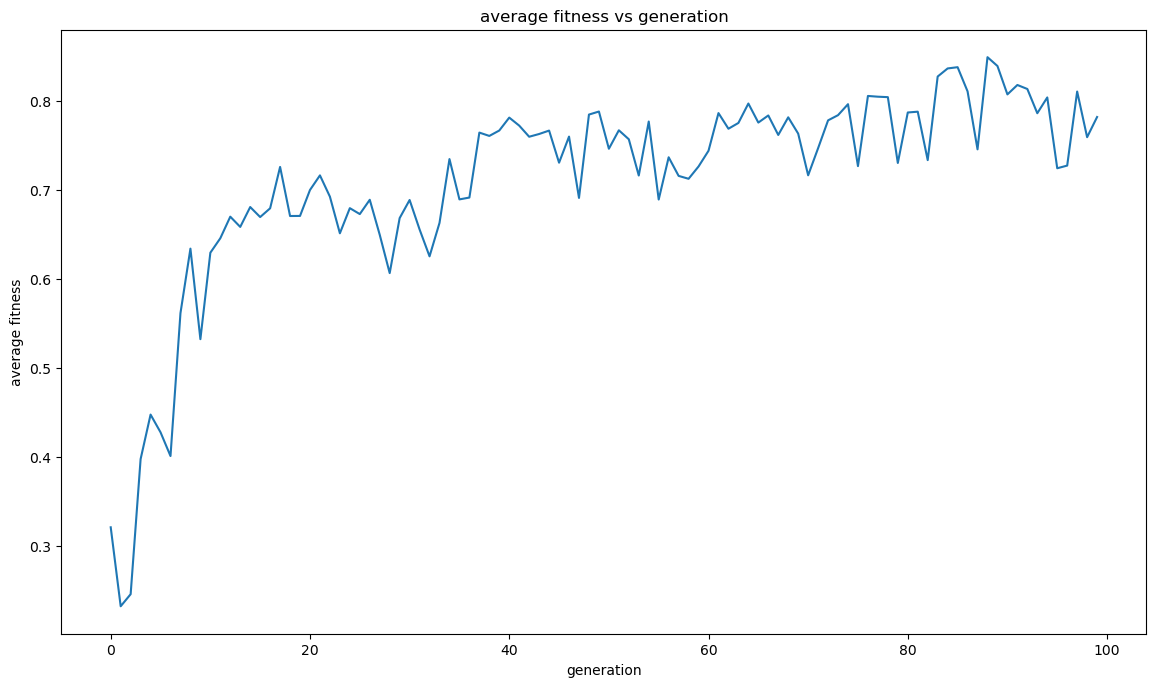

In [230]:
plt.title("average fitness vs generation")
plt.plot(fitness_history)
plt.ylabel("average fitness"), plt.xlabel("generation")
plt.show()

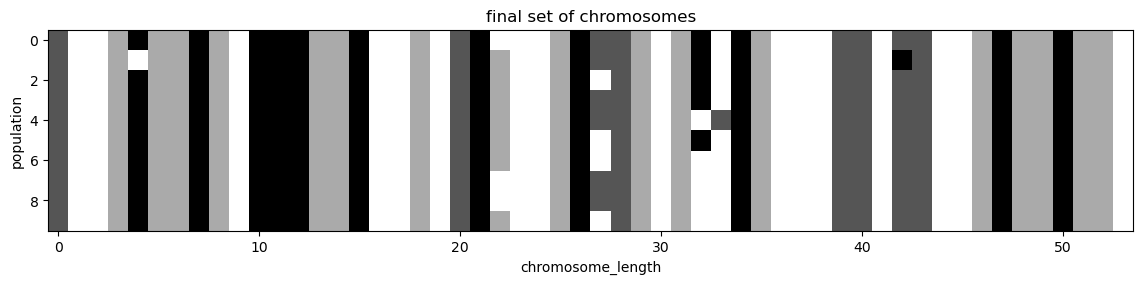

In [231]:
plt.title("final set of chromosomes")
plt.imshow(population)
plt.ylabel("population"), plt.xlabel("chromosome_length")
plt.show()

In [232]:
best_fitness = []
for i in range(N):
    fitness, x, y = painter_play(population[i], room)
    best_fitness.append(fitness)
    
best_chromosome = population[np.argmax(best_fitness)] # the chromosome with the best fitness among the 100 at the final generation
print(max(best_fitness))

0.9083333333333333


KeyboardInterrupt: 

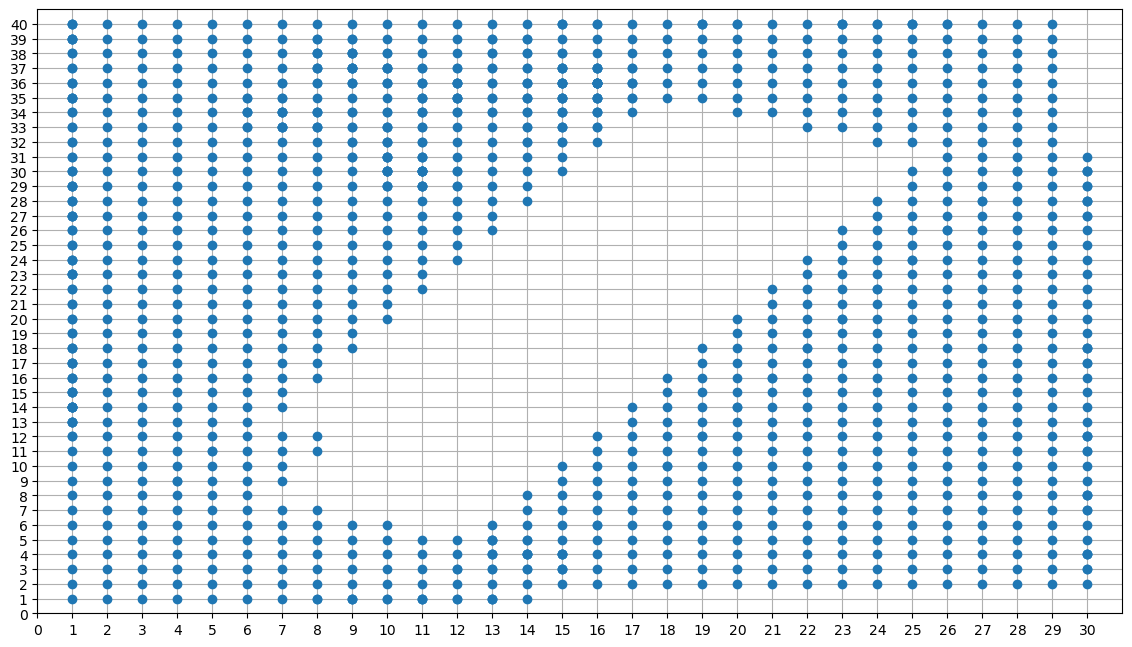

In [233]:
x, y = np.c_[painter_play(best_chromosome, room)[1:]].T

fig, ax = plt.subplots()

# Set the scale of x and y axis
ax.set_xlim([0, Nx+1])
ax.set_ylim([0, Ny+1])
ax.set_xticks(range(0, Nx+1))
ax.set_yticks(range(0, Ny+1))
ax.grid(True)

# The particle's path is represented by a line object in the plot
line, = ax.plot(x[0], y[0], 'o')

# Animation update function
def update(num, x, y, line):
    line.set_data(x[:num], y[:num])
    line.axes.figure.canvas.draw()
    return line,

# Create the animation
ani = FuncAnimation(fig, update, len(x), 
                    fargs=[x, y, line],
                    interval=25, blit=True)
ani.save("painter_movie.gif", writer="pillow")

# Part 2
Write a code which does the following:
1) Take any three points in a plane to form a triangle.
2) Randomly select any point inside the triangle and consider that your current position.
3) Randomly select any one of the three vertex points (with some probabilities $p_1 + p_2 + p_3 = 1$). 
4) Move half the distance from your current position to the selected vertex. Suppose we have two position vectors $a$ and $b$, the vector pointing from $a$ to $b$ is given by the difference $b - a$. The point halfway between a and b is then $a + 0.5 * (b - a) = (a + b) / 2$.
5) After first hundred steps, start plotting the current position.
6) Repeat from step 3).

When the probabilities are equal we get a Sierpinski triangle that looks relatively uniformly distributed.

100%|██████████| 10100/10100 [00:00<00:00, 29616.96it/s]


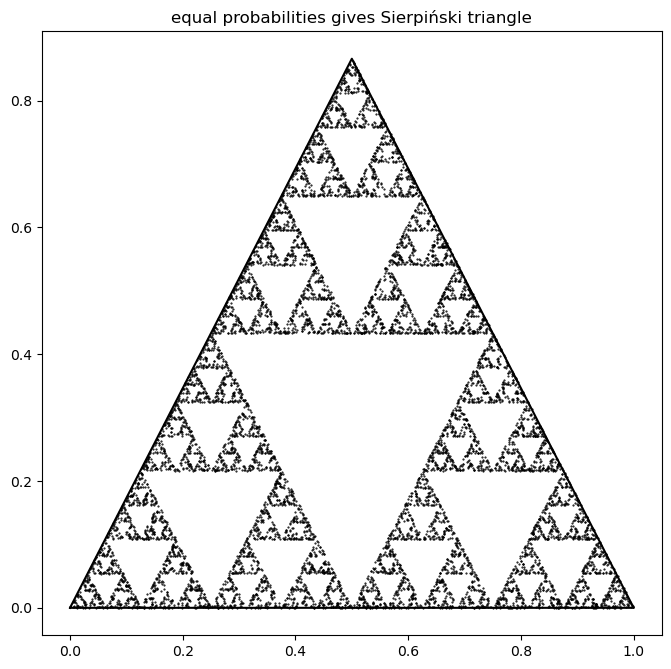

In [335]:
# Vertices for an equallatteral triangle
vertices = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2]])

# Randomly select a point within the triangle
s = np.random.rand()
t = np.random.rand()
if s + t > 1:
    s = 1 - s
    t = 1 - t
current_position = (1 - s - t) * vertices[0] + s * vertices[1] + t * vertices[2]

# Probabilities for each vertex
probabilities = np.array([1, 1, 1]) / 3

# Storage for positions
time_steps = 100 + 10000
positions = np.zeros((time_steps, 2))  # 100 for warmup and remaining for actual steps

for i in tqdm(range(time_steps)):
    # Randomly select a vertex based on probabilities
    vertex = vertices[np.random.choice(3, p=probabilities)]

    # Move halfway towards the selected vertex
    current_position = (current_position + vertex) / 2
    
    positions[i] = current_position

# Extract the positions after the 100th step
positions_after_100_steps = positions[100:]

plt.figure(figsize=(8, 8))
plt.title("equal probabilities gives Sierpiński triangle")
plt.plot(*np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2], [0, 0]]).T, "k-")
plt.plot(*positions_after_100_steps.T, "k.", ms=1)

The Sierpinski triangle still remains, but the dots are not longer uniformly dtsirbuted along the sides of the triangle.

100%|██████████| 100100/100100 [00:02<00:00, 33674.42it/s]


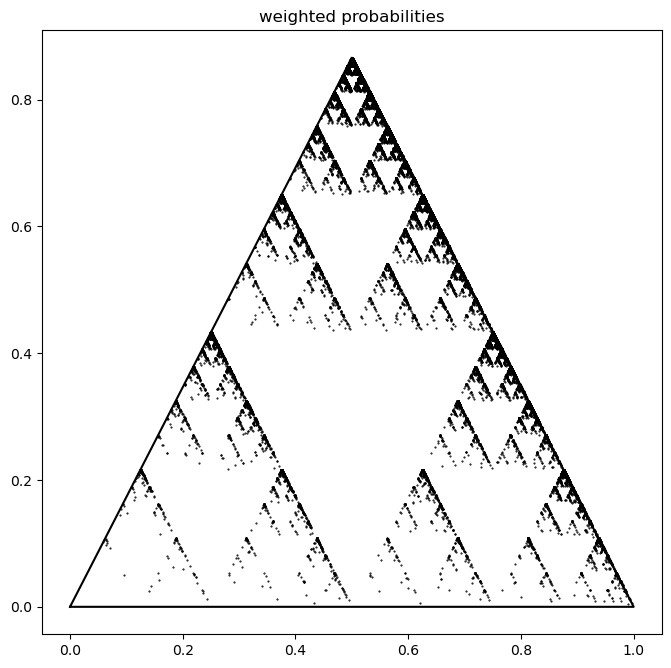

In [334]:
probabilities = [0.05, 0.2, 0.75]
time_steps = 100 + 100000
positions = np.zeros((time_steps, 2))  # 100 for warmup and remaining for actual steps

for i in tqdm(range(time_steps)):
    # Randomly select a vertex based on probabilities
    vertex = vertices[np.random.choice(3, p=probabilities)]

    # Move halfway towards the selected vertex
    current_position = (current_position + vertex) / 2
    
    positions[i] = current_position

# Extract the positions after the 100th step
positions_after_100_steps = positions[100:]

plt.figure(figsize=(8, 8))
plt.title("weighted probabilities")
plt.plot(*np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2], [0, 0]]).T, "k-")
plt.plot(*positions_after_100_steps.T, "k.", ms=1)

## Question two
The core part of the algorithm is described by the following line of code (current_position + vertex) / 2. 
This says that the initial point will move towards a random vertex determined by the probability. The destination of the point is the midpoint of the initial position and the vertex. To describe each action of the point, let us define the functions $f^1_{p_1}(x, y) = ((x+v_{x1})/2, (y+v_{y1})/2), f^2_{p_2}(x, y) = ((x+v_{x2})/2, (y+v_{y2})/2), f^3_{p_3}(x, y) = ((x+v_{x3})/2, (y+v_{y3})/2)$ where $v_{xi}$ and $v_{yi}$ describes the x- and y-coordinates of the traingle vertices. Note how the functions are parameterized by the probabilities $p_i$ which determines the probability to trigger the 